In [ ]:
#!/usr/bin/env python
from __future__ import print_function
import numpy as np
from time import time
#import os
import sys
import gc
import cProfile
import math

import torch
#import torch.nn as nn
import torch.optim as optim
#from torch.utils.data import DataLoader, Subset
#from torchvision import transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning import LightningModule, Trainer
#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data.distributed import DistributedSampler
from pytorch_lightning import LightningDataModule
from pytorch_lightning.callbacks import Callback,TQDMProgressBar
from torch.optim.lr_scheduler import LambdaLR


from tqdm import tqdm

sys.path.append("/projects/bdoy/vsouzaramos/Wavenet_torch")
#print("importing models")
#from Wavenet_torch.models_torch_2channel import *
from models_torch import *
#print("importing data generators")
#from Wavenet_torch.data_generators_torch import *
from data_generators_torch import *
#from custom_callbacks_torch import *

print(torch.__version__)

import argparse
from datetime import datetime

torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('medium')

from pytorch_lightning.utilities import rank_zero_only

In [ ]:
parser = argparse.ArgumentParser(description="Hyperparameter tests")

parser.add_argument('--batch_size', type=int, help='batch size', default=32)
parser.add_argument('--data_dir', help='root directory', default='/projects/bdoy/vsouzaramos/data/data_highmass') #spin waveform
parser.add_argument('--checkpoint_dir', help='root directory', default='/projects/bdoy/vsouzaramos/Hyperparameter_tests/checkpoints')
parser.add_argument('--resume_model', help='model directory', default='/projects/bdoy/vsouzaramos/Hyperparameter_tests/checkpoints')
parser.add_argument('--noise_dir', help='noise directory', default='/projects/bdoy/vsouzaramos/data/processed_noise/') #spin noise
parser.add_argument('--n_channels', type=int, help='number of channels', default=2)
parser.add_argument('--num_workers', type=int, help='number of workers in dataloader', default=1)
parser.add_argument('--num_nodes', type=int, help='number of nodes', default=1)
parser.add_argument('--lr_init', type=float, help='initial learning rate', default=0.001)
parser.add_argument('--initial_epoch', type=int, help='Initial epoch for training continuation', default=0)
parser.add_argument('--plot_sample_waveforms', type=bool, help='whether or not to plot sample waveforms', default=True)
parser.add_argument('--resume_checkpoint', type=str, help='checkpoint filename to resume from (relative to checkpoint_dir)', default='model.ckpt')
parser.add_argument('--run_dir', type=str, help='run directory', default='/projects/bdoy/vsouzaramos/Hyperparameter_tests')

args, unknown = parser.parse_known_args()
print("Parsed arguments:", args)
print("Unknown arguments:", unknown)
    
print(f"----------------------\nArguments:\nbatch size: {args.batch_size}\ndata dir: {args.data_dir}\ncheckpoint_dir: {args.checkpoint_dir}\nresume_model: {args.resume_model}\nnoise_dir {args.noise_dir}\nn_channels {args.n_channels}\nnum_workers {args.num_workers}\nnum_nodes {args.num_nodes}\nlr_init {args.lr_init}\ninitial_epoch {args.initial_epoch}\nplot_sample_waveforms {args.plot_sample_waveforms}\nresume_checkpoint {args.resume_checkpoint}\nrun_dir {args.run_dir}\n----------------------")

In [ ]:
#------- plot some samples -------
if args.plot_sample_waveforms:
    
    print('plotting waveforms', flush=True)
    data_module = WaveformDataModule(
        noise_dir=args.noise_dir,
        data_dir=args.data_dir,
        batch_size=args.batch_size,
        noise_prob=0.33,
        num_workers=args.num_workers,
        p_higher_init=1,
        p_higher_fin=0.99
    )
    
    data_module.setup(stage='fit')                   
    dataset = data_module.train_dataset           
    dataset.plotsamples = True
    plain_loader = torch.utils.data.DataLoader(   # no DistributedSampler
        dataset,
        batch_size = data_module.batch_size,
        shuffle    = True,       
        num_workers= 0           
    )
    X_batch, y_batch, snr_batch, wL_clean, wH_clean = next(iter(plain_loader))
    
    plot_examples(
        X_batch.numpy(),
        y_batch.numpy(),
        snr_batch.numpy(),
        wL_clean.numpy().copy(),
        wH_clean.numpy().copy(),
        save_path="training_batch_preview.png"
    )
    print("Saved training_batch_preview.png")


In [ ]:
#----- define dataloders -----    
print('defining dataloaders', flush=True)
data_module = WaveformDataModule(
    noise_dir=args.noise_dir,
    data_dir=args.data_dir,
    batch_size=args.batch_size,
    split_ratio=0.8,
    noise_prob=0.65,
    num_workers=args.num_workers,
    p_higher_init=0.6,
    p_higher_fin=0.2
)

# Printing all psds

In [ ]:
psd_H_1 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_H_1240989696.pkl", 'rb'), encoding="bytes")
psd_H_2 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_H_1241128960.pkl", 'rb'), encoding="bytes")
psd_H_3 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_H_1242738688.pkl", 'rb'), encoding="bytes")

psd_L_1 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_L_1240989696.pkl", 'rb'), encoding="bytes")
psd_L_2 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_L_1241128960.pkl", 'rb'), encoding="bytes")
psd_L_3 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_L_1242738688.pkl", 'rb'), encoding="bytes")

In [ ]:
Nt = 4096
dt = 1.0 / 4096
freqs  = np.fft.rfftfreq(Nt, dt)

In [ ]:
fig,ax=plt.subplots(figsize=(10, 5))

for psd in [psd_H_1, psd_H_2, psd_H_3, psd_L_1, psd_L_2, psd_L_3]:
    ax.plot(freqs, psd(freqs))
    ax.set_yscale('log')


In [ ]:
file_handlers = [h5py.File(f, 'r') for f in ['/projects/bdoy/vsouzaramos/data/data_highmass/train.hdf5']]
file_idx = 0
sample_idx=0

f = file_handlers[file_idx]
raw_L1 = f['data'][sample_idx, 0]
raw_H1 = f['data'][sample_idx, 1]
signal_len = len(raw_L1)

In [ ]:
def matched_filter_snr(signal, psd, dt, floor=1e-40):
    Nt     = len(signal)
    freqs  = np.fft.rfftfreq(Nt, dt)
    hf     = np.fft.rfft(signal)
    print(f"hf[0]: {hf[0]}")
    Sn     = np.maximum(psd(freqs), floor)
    suspicious = psd(freqs) < floor          # pick a safer threshold
    print(f"bins psd below floor: {np.sum(suspicious)}")
    rho2   = 4.0 * np.sum((np.abs(hf)**2) / Sn) * dt
    return np.sqrt(rho2)

def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    #norm = 1./np.sqrt(1./(dt*2))
    norm=1
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [ ]:
rho_raw = matched_filter_snr(raw_L1, psd_L_1, dt)
rho_white = matched_filter_snr(whiten(raw_L1, psd_L_1, dt),
                               lambda f: 1.0, dt)
print(rho_raw, rho_white)        # should agree to within ~1 %

# Debug

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal_and_psd(signal, psd_interp, dt, label='L1'):
    freqs = np.fft.rfftfreq(len(signal), dt)
    hf = np.fft.rfft(signal)
    power = np.abs(hf)**2

    plt.figure(figsize=(8, 5))
    plt.loglog(freqs, power, label=f'{label} Signal Power')
    plt.loglog(freqs, psd_interp(freqs), label=f'{label} PSD', linestyle='--')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power / PSD")
    plt.title(f"{label}: Signal Spectrum vs PSD")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
plot_signal_and_psd(raw_L1, psd_L_1, dt=dt, label="L1")
plot_signal_and_psd(raw_H1, psd_H_1, dt=dt, label="H1")


In [ ]:
freqs = np.fft.rfftfreq(len(raw_L1), dt)
hf = np.fft.rfft(raw_L1)
power = np.abs(hf)**2
sn_vals = psd(freqs)

band = (freqs > 30) & (freqs < 300)  # or wherever most signal is
print(f"Mean signal power in band: {np.mean(power[band]):.2e}")
print(f"Mean PSD in band: {np.mean(sn_vals[band]):.2e}")

# New debug

In [1]:
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt

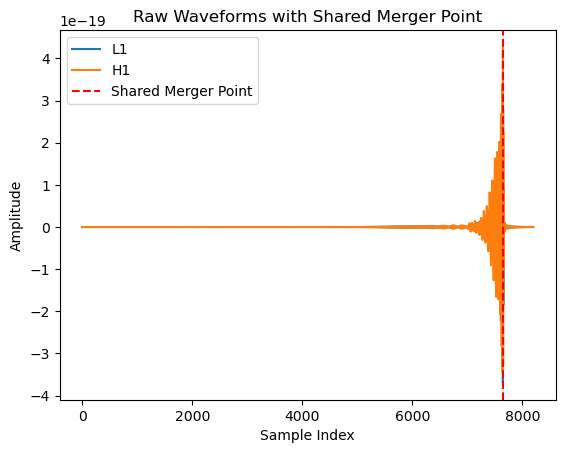

In [2]:
file_handlers = [h5py.File(f, 'r') for f in ['/projects/bdoy/vsouzaramos/data/data_highmass/train.hdf5']]
#file_handlers = [h5py.File(f, 'r') for f in ['/projects/bdoy/vsouzaramos/data/BNS/mydata001.hdf5']]
file_idx = 0
sample_idx=0

f = file_handlers[file_idx]
raw_L1_kiet = f['data'][sample_idx, 0]
raw_H1_kiet = f['data'][sample_idx, 1]
#raw_L1 = f['/waveform/L1'][sample_idx]
#raw_H1 = f['/waveform/H1'][sample_idx]
signal_len = len(raw_L1_kiet)

merger_L1 = np.argmax(np.abs(raw_L1_kiet))
merger_H1 = np.argmax(np.abs(raw_H1_kiet))
shared_merg = (merger_L1 + merger_H1) // 2

plt.plot(raw_L1_kiet, label='L1')
plt.plot(raw_H1_kiet, label='H1')
plt.axvline(shared_merg, color='red', linestyle='--', label='Shared Merger Point')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Raw Waveforms with Shared Merger Point')
plt.legend()

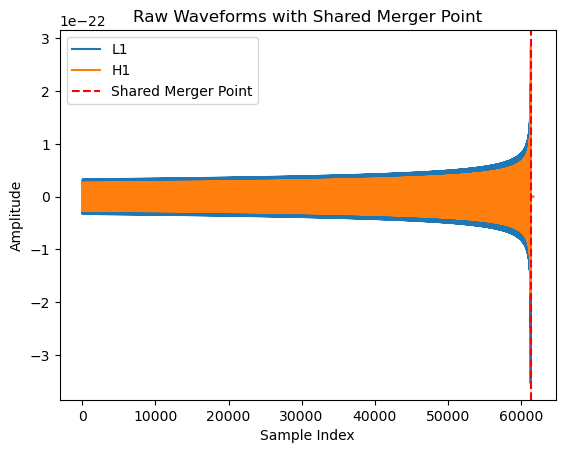

In [3]:
#file_handlers = [h5py.File(f, 'r') for f in ['/projects/bdoy/vsouzaramos/data/data_highmass/train.hdf5']]
file_handlers = [h5py.File(f, 'r') for f in ['/projects/bdoy/vsouzaramos/data/BNS/mydata001.hdf5']]
file_idx = 0
sample_idx=0

f = file_handlers[file_idx]
#raw_L1 = f['data'][sample_idx, 0]
#raw_H1 = f['data'][sample_idx, 1]
raw_L1_haas = f['/waveform/L1'][sample_idx]
raw_H1_haas = f['/waveform/H1'][sample_idx]
signal_len = len(raw_L1_haas)

merger_L1 = np.argmax(np.abs(raw_L1_haas))
merger_H1 = np.argmax(np.abs(raw_H1_haas))
shared_merg = (merger_L1 + merger_H1) // 2

plt.plot(raw_L1_haas, label='L1')
plt.plot(raw_H1_haas, label='H1')
plt.axvline(shared_merg, color='red', linestyle='--', label='Shared Merger Point')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Raw Waveforms with Shared Merger Point')
plt.legend()

In [4]:
noise_handlers = [h5py.File(p, "r") for p in ['/projects/bdoy/vsouzaramos/data/processed_noise/raw_strains_1240989696.hdf5']]
idx_noise = 0

nf        = noise_handlers[idx_noise]               
keyL, keyH = idx_noise*2, idx_noise*2 + 1

psd_H1 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_H_1240989696.pkl", 'rb'), encoding="bytes")
psd_L1 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_L_1240989696.pkl", 'rb'), encoding="bytes")

full_nL = nf['strain_L1'][:]
full_nH = nf['strain_H1'][:]



/tmp/ipykernel_1412890/3691201833.py:7: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  psd_H1 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_H_1240989696.pkl", 'rb'), encoding="bytes")
/tmp/ipykernel_1412890/3691201833.py:8: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  psd_L1 = pickle.load(open("/projects/bdoy/vsouzaramos/data/processed_noise/psd_L_1240989696.pkl", 'rb'), encoding="bytes")


In [5]:
def matched_filter_snr(signal, psd, dt, floor=1e-40):
    Nt     = len(signal)
    freqs  = np.fft.rfftfreq(Nt, dt)         # frequencies
    hf     = np.fft.rfft(signal)             # FFT of the signal
    Sn     = np.maximum(10*psd(freqs), floor)   # evaluate PSD at freqs, apply floor
    rho2   = 4.0 * np.sum((np.abs(hf)**2) / Sn) * dt
    return np.sqrt(rho2)

In [8]:
fs = 4096
dt = 1 / fs
floor= 1e-40
matched_filter_snr(raw_L1_kiet, psd_L1, dt, floor=floor)

371.02675470883514

In [9]:
fs = 4096
dt = 1 / fs
floor= 1e-40
matched_filter_snr(raw_L1_haas, psd_L1, dt, floor=floor)

4.353077864786019

Text(0.5, 1.0, 'Signal vs Noise')

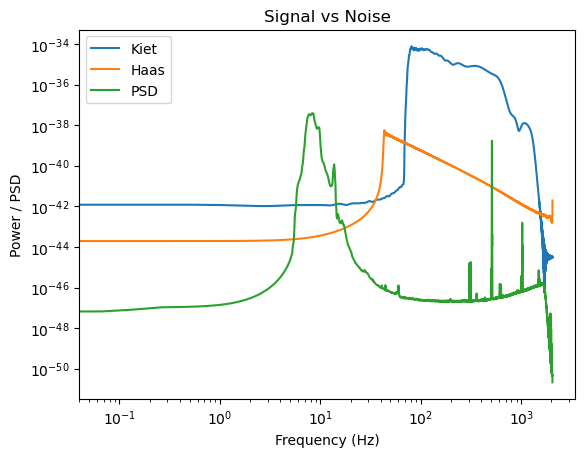

In [15]:
Nt     = len(raw_L1_kiet)
freqs = np.fft.rfftfreq(Nt, dt)
hf = np.fft.rfft(raw_L1_kiet)
plt.loglog(freqs, np.abs(hf)**2, label="Kiet")

Nt     = len(raw_L1_haas)
freqs = np.fft.rfftfreq(Nt, dt)
hf = np.fft.rfft(raw_L1_haas)
plt.loglog(freqs, np.abs(hf)**2, label="Haas")
plt.loglog(freqs, psd_L1(freqs), label="PSD")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power / PSD")
plt.title("Signal vs Noise")

## Computing psd

In [ ]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

In [ ]:
fs = 4096  # Sampling rate in Hz
nperseg = 4 * fs  # 4-second segments (recommended: 4–8 sec)

In [ ]:
freqs, psd = welch(
    full_nL,
    fs=fs,
    window='hann',
    nperseg=nperseg,
    noverlap=nperseg // 2,  # 50% overlap
    detrend='constant',
    scaling='density',
    return_onesided=True
)

In [ ]:
from scipy.interpolate import interp1d

psd_interp = interp1d(freqs, psd, bounds_error=False, fill_value=np.inf)


In [ ]:
# Evaluate the old PSD at the same frequency bins as the new PSD
psd_old = psd_L1(freqs)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.loglog(freqs, psd, label="New PSD (Welch from noise)", color="blue")
plt.loglog(freqs, psd_old, label="Old PSD (loaded)", color="orange", linestyle="--")

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD [$\mathrm{strain^2/Hz}$]")
plt.title("Comparison of New and Existing PSDs")
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.xlim(00, 3000)  # typical GW band
plt.tight_layout()
plt.show()
